## Plot Training Metrics
This notebook reads the training logs and visualizes episode rewards and TD loss. It skips loss plotting if the TensorBoard logs directory is missing.

version 2: add loss

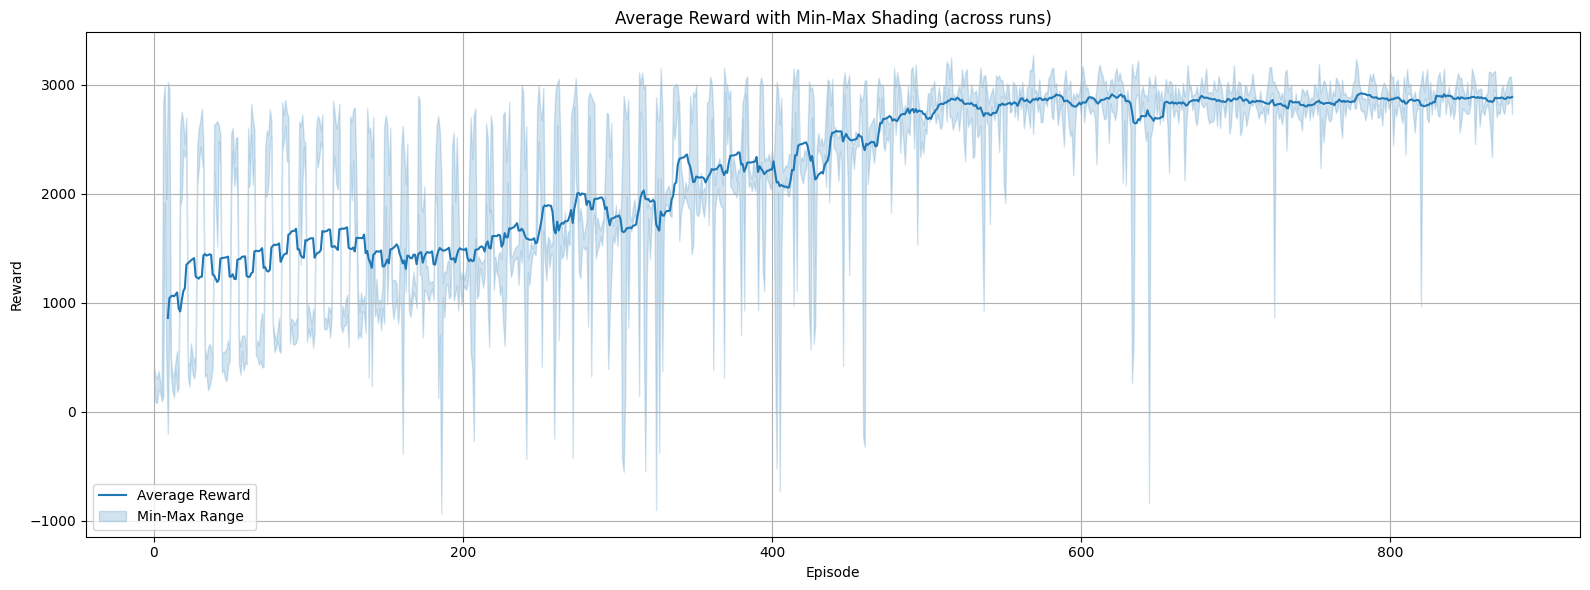

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# 設定路徑與搜尋所有 reward 檔案
base_dir = r"C:\Users\young\Documents\5G-SAC-RAC-KD\logs"
monitor_files = sorted(glob.glob(os.path.join(base_dir, "monitor_run*.csv.monitor.csv")))

all_rewards = []

# 讀取每個檔案的 reward 值
for path in monitor_files:
    try:
        df = pd.read_csv(path, skiprows=1)
        if "r" in df.columns:
            all_rewards.append(df["r"].reset_index(drop=True))  # 重設 index 以便對齊
    except Exception as e:
        print(f"❌ Failed to read {path}: {e}")

# 將所有 reward 合併為 DataFrame（每欄一個 run）
reward_df = pd.DataFrame(all_rewards).T  # transpose 後每行為 episode

# 計算平均值與最大/最小區間
mean_reward = reward_df.mean(axis=1).rolling(window=10).mean()
min_reward = reward_df.min(axis=1)
max_reward = reward_df.max(axis=1)

# 繪圖
plt.figure(figsize=(16, 6))
x = np.arange(len(mean_reward))
plt.plot(x, mean_reward, label="Average Reward", color="tab:blue")
plt.fill_between(x, min_reward, max_reward, color="tab:blue", alpha=0.2, label="Min-Max Range")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average Reward with Min-Max Shading (across runs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Found 3 TensorBoard event files.
✅ Run 1: Loaded 200 steps
✅ Run 2: Loaded 200 steps
✅ Run 3: Loaded 200 steps


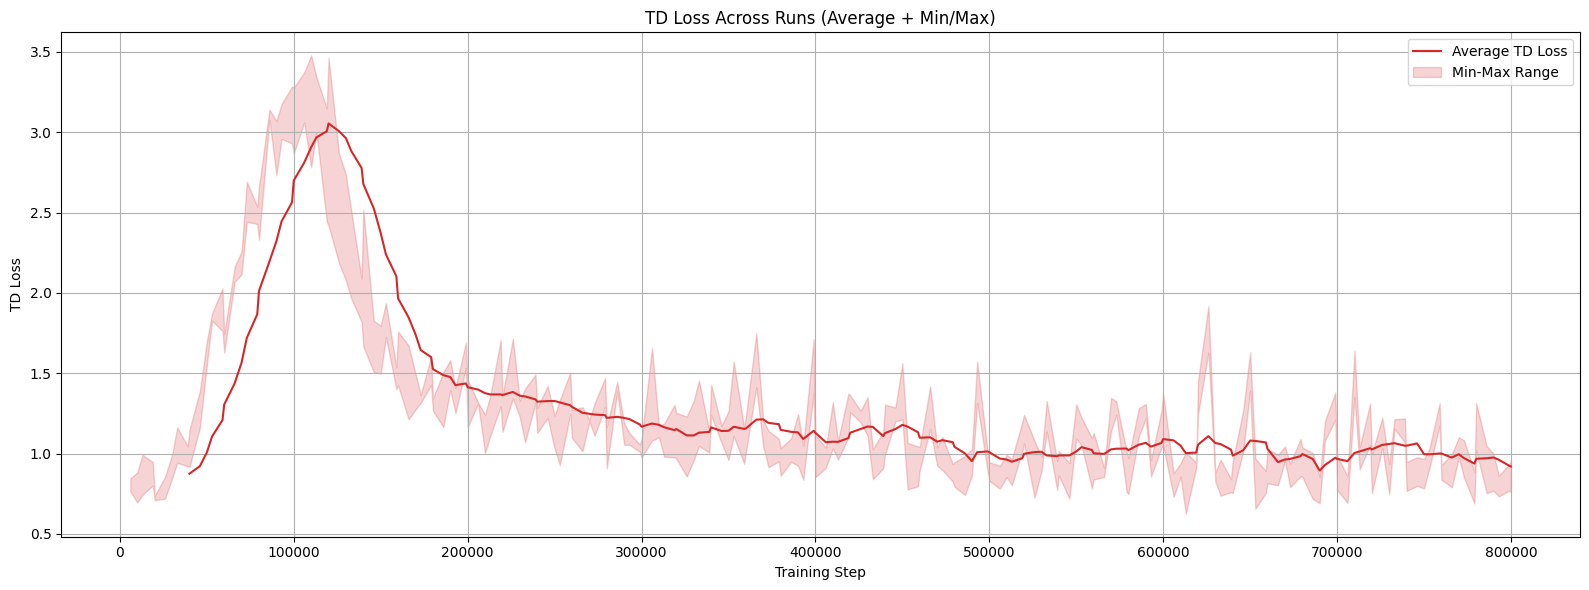

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 設定 TensorBoard logs 資料夾
tb_root = r"C:\Users\young\Documents\5G-SAC-RAC-KD\logs\tensorboard"
event_files = glob.glob(os.path.join(tb_root, '**', 'events.out.tfevents*'), recursive=True)

print(f"🔍 Found {len(event_files)} TensorBoard event files.")

# 收集所有 run 的 loss 序列（以 step 對齊）
all_losses = []
max_step = 0

for i, path in enumerate(event_files):
    try:
        ea = EventAccumulator(path)
        ea.Reload()
        if "train/loss" in ea.Tags()["scalars"]:
            evs = ea.Scalars("train/loss")
            steps = [e.step for e in evs]
            losses = [e.value for e in evs]
            series = pd.Series(losses, index=steps)
            all_losses.append(series)
            max_step = max(max_step, steps[-1])
            print(f"✅ Run {i+1}: Loaded {len(steps)} steps")
        else:
            print(f"⚠️ Run {i+1}: 'train/loss' not found")
    except Exception as e:
        print(f"❌ Run {i+1} failed to load: {e}")

# 對齊所有 Series → DataFrame（每欄一個 run）
loss_df = pd.DataFrame(all_losses).T.sort_index()

# 計算統計量
mean_loss = loss_df.mean(axis=1).rolling(window=10).mean()
min_loss = loss_df.min(axis=1)
max_loss = loss_df.max(axis=1)

# 畫圖
plt.figure(figsize=(16, 6))
x = mean_loss.index
plt.plot(x, mean_loss, color="tab:red", label="Average TD Loss")
plt.fill_between(x, min_loss, max_loss, color="tab:red", alpha=0.2, label="Min-Max Range")
plt.xlabel("Training Step")
plt.ylabel("TD Loss")
plt.title("TD Loss Across Runs (Average + Min/Max)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
